# Spaceship Titanic
Welcome to the year 2908, where the data science skills of Future Insurance Investigator (FII) Matthew Fullhart are needed to solve a cosmic mystery. We've received a transmission from our Time Scouts four years in the future and things aren't looking good.

The Spaceship Titanic is an interstellar passenger liner launched a month ago towards Alpha Centauri. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

Our Time Scouts report that while rounding Alpha Centauri en route to its first destination -55 Cancri E- the unwary Spaceship Titanic is fated to collide with a spacetime anomaly hidden within a dust cloud. Sadly, it will meet a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers will be transported to an alternate dimension! 

As the ship is already traveling at the speed of light, transmission to the ship will be impossible until it drops out of lightspeed upon approach to Alpha Centauri. They will have a very short window to act upon our information, to avoid this terrible fate. Fortunately, we have some information on our side. Our Time Scouts managed to secure a portion of the ship's manifest, along with the fates of those contained within. Unfortunately for us, the ship's computer core was also damaged in the collision, and as such, we are missing approximately 1/3 of the passenger manifest, along with all data about exactly where and how the collision occurred.

To help prevent catastrophe, and also to prevent legal claims of the lost passengers from bankrupting the Titanic Starship Company, FII Matthew Fullhart must create a data science model that predicts with the greatest accuracy which passengers were lost among the remaining 1/3 of passengers with unknown fates. He hopes this information will also prove useful to those aboard the ship, as learning who was affected and where on the ship they were at the time may help the ship avoid the collision in the first place.

He must help save them and change history!

### First, let's import the necessary libraries:

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport as ppr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import StratifiedKFold as KFold, GridSearchCV as GridSearch, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from IPython.display import display
pd.set_option('display.max_columns', None)

#### ... and read in training and testing data:

In [2]:
df = pd.read_csv("Data/train.csv")
df_test =pd.read_csv("Data/test.csv")

### Now, let's Explore the data with some basic pandas functions:

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
df.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


### Let's also generate a more detailed report using the ydata-profiling library:

In [7]:
report = ppr(df)
report.to_file("ReportExploration.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Interesting!
Looks like we've got a bunch of missing values, some strange zero values (age should definitely not be zero), and some high negative corelations (probably the passengers who are in cryosleep aren't using the stuff that costs money)

It's also quite depressing that 900+ years from now, the oldest person on board is only 79. I was hoping by then we'd have figured out how to live longer than that. Perhaps they do live longer then, but there's a norm against traveling offworld after you reach a certain age? Let's go with that for optimism's sake!

On the plus side, if the money involved is in Dollars, the currency has been remarkably stable for a thousand years. This has deep implications for the coming 900 years.

But all kidding aside, it appears as though <u>those in cryosleep</u> were <i>more likely</i> to be transported to the alternate dimension, and those who had a high bill in the <u>VR Deck</u> were <i>less likely</i> to be transported.

## Next, let's clean our data

First, let's decide what to do with each of our missing values. For fields where both a majority made a particular selection, and where the field is missing less than 5%, let's infer that those with missing values probably also chose the most common option. Fields that match these circumstances (and their most common occurence) are as follows:<br>
HomePlanet  (Earth)<br>
Destination (TRAPPIST-1e)<br>
VIP         (False)<br>

In [8]:
def Clean_Pt1(df):
    df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
    df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
    df['VIP'] = df['VIP'].fillna(df['VIP'].mode()[0])
    Missing_HP_D_VIP = df['HomePlanet'].isna().sum() + df['Destination'].isna().sum() + df['VIP'].isna().sum()
    print(f"There are {Missing_HP_D_VIP} values missing from HomePlanet, Destination, or VIP")
    return df
df = Clean_Pt1(df)

There are 0 values missing from HomePlanet, Destination, or VIP


You may notice that Cryosleep wasn't on that list, despite meeting the criteria. That's because we have other clues that can help us impute the missing items in that column. I highly suspect Cryosleeping passengers cannot spend money at the luxury amenities! So let's explore whether that's true, and if it is, we can say for certain if any money was spent at those, that the passenger is not a cryosleeper. Let's also explore whether there are passengers who were not cryofrozen, and yet didn't spend money at the luxury venues. <br>
It'd actually be really helpful here to have a boolean value for whether any money was spent at any of the 5 luxury venues, so let's create that column, and compare it to the CryoSleep column.

In [9]:
def Clean_Pt2(df):
    #add all 5 columns up...
    df['total_spent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    #compute how many fall into the extremes we mentioned above...
    unfrozen_stoics = df[(df['total_spent'] == 0) & (df['CryoSleep'] == False)].shape[0]
    frozen_spenders = df[(df['total_spent']  > 0) & (df['CryoSleep'] == True) ].shape[0]
    print(f"There are {frozen_spenders} passengers who spent money while cryosleeping, \nand {unfrozen_stoics} passengers who spent no money while not frozen")
    #and compute the percentage of unfrozen folks who don't spend
    unfrozen_percent = round(((unfrozen_stoics)/(df[df['CryoSleep'] == False].shape[0])*100),2)
    print(f"Only {unfrozen_percent}% of Non-frozen passengers have foregone luxuries for the whole trip")
    return df
df = Clean_Pt2(df)

There are 0 passengers who spent money while cryosleeping, 
and 518 passengers who spent no money while not frozen
Only 9.52% of Non-frozen passengers have foregone luxuries for the whole trip


Looks like I was right that Cryosleepers can't spend money. It also looks like the vast majority of non-cryosleepers spend money, which helps us make our determination easy. Given how skewed both results are, if we have knowledge that the person spent money, we'll mark them as not having been frozen, and if we don't have knowledge that they spent money (including if some or all of the luxury columns are blank) then we'll mark them as having been frozen.

In [10]:
def Clean_Pt3(df):
    # Impute 'True' in CryoSleep for passengers with zero spending
    df.loc[(df['CryoSleep'].isna()) & (df['total_spent'] == 0), 'CryoSleep'] = True
    
    # Impute 'False' in CryoSleep for customers who spent more than 0 money
    df.loc[(df['CryoSleep'].isna()) & (df['total_spent'] > 0), 'CryoSleep'] = False
    Null_Cryo = df['CryoSleep'].isna().sum()
    print(f"There are {Null_Cryo} missing values in the CryoSleep column now!")
    return df
df = Clean_Pt3(df)

There are 0 missing values in the CryoSleep column now!


Let's take a look at what missing items remains using the .isnull().sum() pandas command:

In [11]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
total_spent       0
dtype: int64

There's a pretty even number of them between the remaining columns. Let's see if any of those null values correspond with the same rows, as the more missing data in a single row, the more justified we are it getting rid of the row.

In [12]:
missing_rows = df[df[['Cabin', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']].isna().any(axis=1)]
print(missing_rows)

     PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
7        0006_02      Earth      True     G/0/S  TRAPPIST-1e  28.0  False   
10       0008_02     Europa      True     B/1/P  TRAPPIST-1e  34.0  False   
15       0012_01      Earth     False       NaN  TRAPPIST-1e  31.0  False   
16       0014_01       Mars     False     F/3/P  55 Cancri e  27.0  False   
23       0020_03      Earth      True     E/0/S  55 Cancri e  29.0  False   
...          ...        ...       ...       ...          ...   ...    ...   
8656     9233_01      Earth     False       NaN  TRAPPIST-1e  41.0  False   
8664     9246_01      Earth      True  G/1490/S  TRAPPIST-1e  32.0  False   
8665     9247_01      Earth      True  G/1491/S  TRAPPIST-1e  33.0  False   
8667     9250_01     Europa     False   E/597/P  TRAPPIST-1e  29.0  False   
8675     9259_01      Earth     False  F/1893/P  TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall   Spa  VRDeck                Nam

Looks like there's not a lot of overlap here, which means we can't really justify deleting almost 20% of our data set based on missing data. Let's go with the median value for the luxury columns, as that avoids being skewed by outliers, and if there's a majority of passengers with the same answer, we'll get the same result as the mode anyway. 

Age is strange. Does 0 make sense as an age? Infants who are less than 1 year old may have been rounded down, as they haven't completed their first year of life yet, so upon reflection, that's a resonable explanation for the 0 values. However, we still have 179 missing values. Let's look at our options:<br>
As a relatively continuous variable, we don't have a good reason to choose mode here, as there's no clear majority. While it doesn't have a good liklihood of finding the real age, the median will reduce the average error to the minimal possible, without deleting those 179 rows. At first glance, Age seems somewhat unlikely to be a factor in transportation to the alternate dimension, but I could see surprising edge cases where a slow impact allowed those who were more mobile or smaller to avoid getting hit by an area of effect. Or perhaps there is a school aboard, and the location of that school could cause an outsized impact for the Age category. Because of that uncertainty, I believe median is the best choice.

In [13]:
def Clean_Pt4(df):
    ImputeMedianCols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age"]
    for col in ImputeMedianCols:
        df[col].fillna(df[col].median(), inplace= True)
    return df
df = Clean_Pt4(df)

In [14]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
total_spent       0
dtype: int64

Still 2 more columns to deal with! Name is extremely unlikely to be relevant to whether a passenger got teleported to the alternate dimension, and we didn't see a corelation there when we explored the data anyway, so dropping that column makes sense. Plus we'll 

In [15]:
def Clean_Pt5(df):
    df = df.drop('Name', axis = 1)
    return df
df = Clean_Pt5(df)

In [16]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
total_spent       0
dtype: int64

That leaves us with Cabin as the only column remaining with null values. Unfortunately, I suspect Cabin may be quite relevant to who was transported to the alternate dimension, as location on the ship during a collision could have great relevance for expected outcome. For now, let's leave those fields blank, and come back to this problem after we do some feature engineering. However, we're still not done with cleaning.

Before we move on, <b>let's transform our skewed features,</b> namely, the dollar value items. Not only are the majority of the results 0 for these columns, but there are some values in each that reach into the tens of thousands. We don't want to confuse our model by leaving these results highly-skewed, so let's transform them by taking the log of the result, so that when we normalize these columns to the same scale, 80 is a value that looks meaningfully different from 0, instead of having a few outlier results throw off the curve wildly.<br>
Speaking of 0, we'll also need to add epislon to any 0 values so that the log doesn't give an undefined error.

In [17]:
def Transform_Pt1(df):
    Log_Cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    for col in Log_Cols:
        zeroes_mask = df[col] == 0
        df.loc[zeroes_mask,col] = np.log(0.1)
        df.loc[~zeroes_mask,col] = np.log(df.loc[~zeroes_mask,col])
    return df
df = Transform_Pt1(df)

In [18]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.790291,0.189027,0.391849,0.039249,0.354256,0.229192,1440.866329
std,14.341404,3.719179,3.933599,3.553245,3.771512,3.740909,2803.045694
min,0.000000,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.000000
25%,20.000000,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.000000
50%,27.000000,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,716.000000
75%,37.000000,3.713572,4.110874,3.091042,3.970292,3.688879,1441.000000
max,79.000000,9.569901,10.302700,10.064415,10.017173,10.091335,35987.000000


## Now that we've cleaned the data we can move on to prepping it!
We can do some feature engineering to enhance our model's ability to notice patterns.

Let's examine our data a little more by breaking out features of Cabin to their constituent bits. If a particular part of the ship was hit by the spacial anomaly, it's possible people there were more likely to be affected. Currently Cabin is a combination field of deck/num/side. <br>
Deck is a letter from A-G or T,<br>
Num in an integer anywhere from 0 to 1894, and...<br>
Side is a letter representing Port (P) or Starboard (S)<br><br>

In [19]:
def Feature_Eng1(df):
    df[["Deck", "Cabin_No", "Cabin_Side"]] = df["Cabin"].str.split("/", expand = True)
    return df
df = Feature_Eng1(df)

<b>While we're at it,</b> let's add the individual components of the PassengerID as well:<br>
Each ID is in the form gggg-pp.<br>
gggg is the group the passenger traveled with, and <br>
pp is the number within the group.<br>
While this seems unlikely to be relevant, people tend to travel in familiar groups while away from home, and it's possible they were all on a specific part of the ship together when the anomaly struck the ship, leading to a small correlation.

In [20]:
def Feature_Eng2(df):
    df[["ID_Group", "ID_No"]] = df["PassengerId"].str.split("_", expand = True)
    return df
df = Feature_Eng2(df)

<b>Now that we've split out room number,</b> we should look toward getting rid of the empty values. The original Cabin column is no longer necessary, as we've split it into its component parts, and don't want to overindex on it, so let's also drop it while we're at it. <br>
Speaking of overindexing, we need to get rid of the total_spent field. It's served its purpose above, and we don't want to have a single variable that corelates with 5 others, so let's drop that one as well.<br>
That'll leave us with only three columns to handle imputations. Let's look at our report again, and see what if anything has changed regarding correlations between our new features.<br>

In [21]:
def Feature_Eng3(df):
    df = df.drop('Cabin', axis = 1)
    df = df.drop(['total_spent'], axis = 1)
    return df
df = Feature_Eng3(df)

In [22]:
report2 = ppr(df)
report2.to_file("ReportPrepping.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
df["Deck"].value_counts()

Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

Interesting! According to our report, Deck is corelated with Home Planet for some reason. None of them are immediately corellated with "Transported," which is disappointing, but perhaps the random forest will see something this rudimentary report can't see.<br>
Since Deck is correlated with Home Planet, we can impute Deck based on Home Planet.<br>
Looks like Cabin_No is another column that should be log-ified, as it has quite a lot of possibilities, and they go into the thousands. Also, there's no single value that is obviously correct, so median seems like the best option. Certainly it is preferable to deleting almost 200 rows that are otherwise fine.<br>
Finally, Cabin_Side seems to be pretty evenly split, without a strong corelation on anything I imediately see. Lots of sub-par options with this one, but I think Mode is probably the best. Ultimately this is less than 2.5 percent of the data for that column, and so imputing the mode is unlikely to significantly skew the results.

In [24]:
def Feature_Eng4(df):
    # Handle HomePlanet / Deck Imputation
    df['Deck'] = df['Deck'].fillna(
        df.groupby('HomePlanet')['Deck'].transform(lambda x: x.mode()[0])
    )
    # For Cabin_No, Impute Median value...
    df["Cabin_No"].fillna(df["Cabin_No"].median(), inplace= True)
    #... then replace the column with the log of itself, to reduce the span of possible values
    df['Cabin_No'] = pd.to_numeric(df['Cabin_No'], errors = 'coerce')
    zeroes_mask = df["Cabin_No"] == 0
    df.loc[zeroes_mask,"Cabin_No"] = np.log(0.1)
    df.loc[~zeroes_mask,"Cabin_No"] = np.log(df.loc[~zeroes_mask,"Cabin_No"])
    # next, Cabin_Side Mode Imputation
    df['Cabin_Side'].fillna(df["Cabin_Side"].mode(), inplace= True)
    # Then transform ID_Group into numeric
    df['ID_Group'] = pd.to_numeric(df['ID_Group'], errors = 'coerce')
    # Then transform ID_Group into Log of itself, because the values have a high range
    zeroes_mask = df['ID_Group'] == 0
    df.loc[zeroes_mask,'ID_Group'] = np.log(0.1)
    df.loc[~zeroes_mask,'ID_Group'] = np.log(df.loc[~zeroes_mask,'ID_Group'])
    # Then transform ID_No into numeric
    df['ID_No'] = pd.to_numeric(df['ID_No'], errors = 'coerce')
    # Lastly, transform CryoSleep from string to Bool
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    return df
df= Feature_Eng4(df)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   bool   
 12  Deck          8693 non-null   object 
 13  Cabin_No      8693 non-null   float64
 14  Cabin_Side    8494 non-null   object 
 15  ID_Group      8693 non-null   float64
 16  ID_No         8693 non-null   int64  
dtypes: bool(3), float64(8), int64(1), object(5)
memory usage: 976.4+ KB


## Now, let's perform some data preprocessing in anticipation of creating the model:

### First, we'll one-hot encode all the categorical data into their own columns

In [26]:
def One_Hot_Encode(df):
    #dropping the first value of columns with few categorical results to avoid overindexing
    df = pd.get_dummies(df, columns=['Deck', 'HomePlanet', 'Destination', 'Cabin_Side'], drop_first=True)
    return df
df = One_Hot_Encode(df)

In [27]:
df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_No,ID_Group,ID_No,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Side_S
0,0001_01,False,39.0,False,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,False,-2.302585,0.000000,1,True,False,False,False,False,False,False,True,False,False,True,False
1,0002_01,False,24.0,False,4.691348,2.197225,3.218876,6.308098,3.784190,True,-2.302585,0.693147,1,False,False,False,False,True,False,False,False,False,False,True,True
2,0003_01,False,58.0,True,3.761200,8.182000,-2.302585,8.812099,3.891820,False,-2.302585,1.098612,1,False,False,False,False,False,False,False,True,False,False,True,True
3,0003_02,False,33.0,False,-2.302585,7.156956,5.916202,8.110427,5.262690,False,-2.302585,1.098612,2,False,False,False,False,False,False,False,True,False,False,True,True
4,0004_01,False,16.0,False,5.713733,4.248495,5.017280,6.336826,0.693147,True,0.000000,1.386294,1,False,False,False,False,True,False,False,False,False,False,True,True


### Next, we'll normalize our numerical columns to the same scale, so that they each apply the same weight for purposes of finding patterns.

In [28]:
def Normalize(df):
    Numerical_Columns = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Cabin_No", "ID_Group", "ID_No"]
    Scaler = MinMaxScaler()
    df[Numerical_Columns] = Scaler.fit_transform(df[Numerical_Columns])
    return df
df = Normalize(df)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                8693 non-null   object 
 1   CryoSleep                  8693 non-null   bool   
 2   Age                        8693 non-null   float64
 3   VIP                        8693 non-null   bool   
 4   RoomService                8693 non-null   float64
 5   FoodCourt                  8693 non-null   float64
 6   ShoppingMall               8693 non-null   float64
 7   Spa                        8693 non-null   float64
 8   VRDeck                     8693 non-null   float64
 9   Transported                8693 non-null   bool   
 10  Cabin_No                   8693 non-null   float64
 11  ID_Group                   8693 non-null   float64
 12  ID_No                      8693 non-null   float64
 13  Deck_B                     8693 non-null   bool 

In [30]:
#Check the data frame to make sure everything looks ready
df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_No,ID_Group,ID_No,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Side_S
0,0001_01,False,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.000000,0.000000,0.000000,True,False,False,False,False,False,False,True,False,False,True,False
1,0002_01,False,0.303797,False,0.589087,0.356978,0.446467,0.698933,0.491110,True,0.000000,0.075873,0.000000,False,False,False,False,True,False,False,False,False,False,True,True
2,0003_01,False,0.734177,True,0.510743,0.831761,0.000000,0.902184,0.499794,False,0.000000,0.120256,0.000000,False,False,False,False,False,False,False,True,False,False,True,True
3,0003_02,False,0.417722,False,0.000000,0.750442,0.664574,0.845229,0.610402,False,0.000000,0.120256,0.142857,False,False,False,False,False,False,False,True,False,False,True,True
4,0004_01,False,0.202532,False,0.675201,0.519709,0.591887,0.701265,0.241710,True,0.233788,0.151746,0.000000,False,False,False,False,True,False,False,False,False,False,True,True


### Lastly, we'll split out our target variable and do some column cleanup!

In [31]:
preserved_df = df.copy()
y = df.pop('Transported')
X = df.drop(columns = ['PassengerId'])


### Now that we're done with preprocessing, we can split the data!
Since Kaggle has given us a set of test data with no target variable, we'll need to split our training data set in a different way. Given that we only have about XXXX entries, I think it's reasonable to do either train-test split, or stratified k-fold cross validation, since we have a moderate amount of data, and the reason to do one or the other of those two validation splits is the size of data.<br><br> 
For this case, let's go with the more-complex-but-also-more-reliable stratified k-fold cross validation. We are trying to save lives after all, and the computers of 2912 are sure to handle the increased computational load much better than our limited 21st century ones will!

In [32]:
Folds = KFold(n_splits = 10, shuffle = True, random_state = 1701)

## Finally, it's time to start modeling!
Given the size of our data set, and the number of variables we have, the Random Forest is my preferred model. It avoids the overfitting problem often encountered in decision-tree models, while still gaining a wisdom-of-the-crowds effect that emerges from each tree in the forest only seeing part of the picture. Much like getting a second opinion when your doctor tells you something, getting a diversity of opinion often leads to better outcomes.<br><br>
If our data set were 1,000 times larger, the increased computational and memory requirements might have led to selecting a different algorithm that doesn't suffer as much as the random forest does from balooning requirements. However with our moderately-sized data set, my computer is more than up to the task on its own. Now we have two reasons to be glad the Spaceship Titanic only had 13,000-ish passengers!

In [33]:
def Grid_Search_func(X, y, Folds):
    rf = RFC(random_state = 1701)
    param_grid = {
        'n_estimators': [100,200,400],
        'max_depth':  [None,10,20,50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf':[1,2,4]
    }
    
    grid_search = GridSearch(
        estimator = rf,
        param_grid = param_grid,
        cv = Folds,
        scoring = 'accuracy',
        n_jobs = 1,
        verbose = 2
    )
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    
    print(f"Best Parameters: {grid_search.best_params_}")
    return grid_search.best_score_, best_model
Best_Score_All, Best_Model_All = Grid_Search_func(X,y,Folds)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END

Now that we have a preliminary trained model, let's check out our metrics. According to a previously-ran grid search, my best hyperparameters with 5 folds are: <br>
'max_depth': 20 <br>
'min_samples_leaf': 2 <br>
'min_samples_split': 5 <br>
'n_estimators': 100 <br>
Which gave an accuracy around 80.6%

...and with these current 10 folds:
'max_depth': 20 <br>
'min_samples_leaf': 2 <br>
'min_samples_split': 10 <br>
'n_estimators': 200 <br>
Which got a better accuracy, which you can see below!

I get a better accuracy score with 10 folds so I'll be using that. It also makes sense, since each fold got trained on more data (90% instead of 80%). Also, the literature indicates that 10 is the ideal number in cases where the computational requirements are not huge, so our results match that!

Remember, the better we do here, the more likely we are to have information that may help prevent the collision with the space-time anomaly, or, barring that, potentially being able to rescue more of the folks who were transported to the alternate dimension. (However, the true test will be later, when we compute the predictions for our test file and submit them to Kaggle.com.) For now, let's look at how close we've gotten so far using :

In [34]:
print(Best_Score_All)

0.8083533722206792


Let's look at a confusion matrix and a classification report:

In [35]:
y_pred_Best_Model = cross_val_predict(Best_Model_All, X, y, cv = 10)
print(confusion_matrix(y,y_pred_Best_Model))
print(classification_report(y, y_pred_Best_Model))

[[3619  696]
 [1227 3151]]
              precision    recall  f1-score   support

       False       0.75      0.84      0.79      4315
        True       0.82      0.72      0.77      4378

    accuracy                           0.78      8693
   macro avg       0.78      0.78      0.78      8693
weighted avg       0.78      0.78      0.78      8693



Let's look an see which columns were the most important:

In [36]:
importances = Best_Model_All.feature_importances_
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances*100
}).sort_values(by= 'Importance', ascending = False)
importances_df['Cumulative_Total'] = importances_df['Importance'].cumsum() / importances_df['Importance'].sum() * 100


/tmp/ipykernel_2980492/2931277444.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(importances_df['Feature'], rotation=45, ha='right')


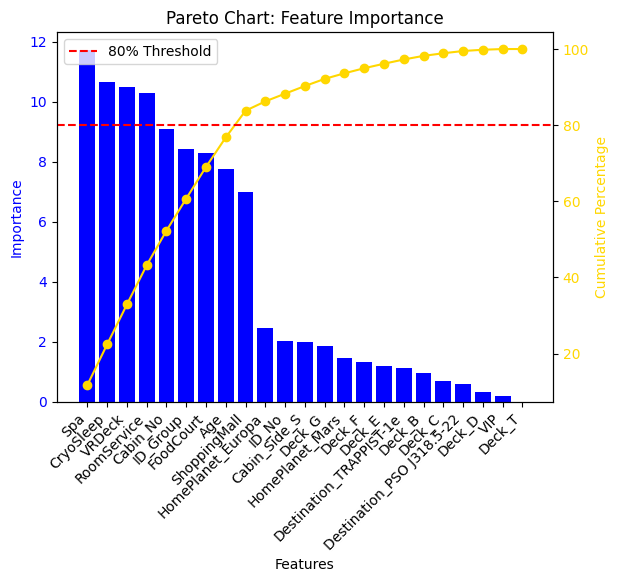

In [37]:
# Let's create a pareto chart to show the importances!
# First, the bar plot for feature importances
fig, ax1 = plt.subplots()

ax1.bar(importances_df['Feature'], importances_df['Importance'], color='blue')
ax1.set_xlabel("Features")
ax1.set_ylabel("Importance", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Pareto Chart: Feature Importance")


# Then, the line plot for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(importances_df['Feature'], importances_df['Cumulative_Total'], color='gold', marker='o')
ax2.set_ylabel("Cumulative Percentage", color='gold')
ax2.tick_params(axis='y', labelcolor='gold')
ax2.axhline(80, color='red', linestyle='--', label="80% Threshold")
ax2.legend(loc="upper left")

# Lastly, Rotate x-axis labels 45 degrees so they don't overlap or take up a huge amount of vertical space
ax1.set_xticklabels(importances_df['Feature'], rotation=45, ha='right')
plt.show()


Looks like there are several columns of our data frame that don't have much predictive power. This can potentially dilute our model by including them. Let's choose 5 threshold values (below which, the column does more to broadcast noise than it does to broadcast signal) and run 5 different runs with differing amounts of columns. If we create a new dataframe with just the columns with predictive power above each threshold, and run our tests again for each, maybe we'll get even better results! Let's try it!
#### In this case, let's choose 2.5%, 1.5%, 1.0%, 0.5% and 0.1%:

In [38]:
X_2_5 = df.drop(['HomePlanet_Europa', 'ID_No', 'Cabin_Side_S', 'Deck_G', 'HomePlanet_Mars', 'Deck_F','Deck_E', 'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Destination_PSO J318.5-22', 'Deck_D', 'VIP', 'Deck_T'], axis = 1)
X_1_5 = df.drop(['Deck_F','Deck_E', 'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Destination_PSO J318.5-22', 'Deck_D', 'VIP', 'Deck_T'], axis = 1)
X_1_0 = df.drop(['Deck_B', 'Deck_C', 'Destination_PSO J318.5-22', 'Deck_D', 'VIP', 'Deck_T'], axis = 1)
X_0_5 = df.drop(['Deck_D', 'VIP', 'Deck_T'], axis = 1)
X_0_1 = df.drop(['Deck_T'], axis = 1)

In [39]:
Best_Score2_5, Best_Model1_5 = Grid_Search_func(X_2_5, y, Folds)
Best_Score1_5, Best_Model1_5 = Grid_Search_func(X_1_5, y, Folds)
Best_Score1_0, Best_Model1_0 = Grid_Search_func(X_1_0, y, Folds)
Best_Score0_5, Best_Model0_5 = Grid_Search_func(X_0_5, y, Folds)
Best_Score0_1, Best_Model0_1 = Grid_Search_func(X_0_1, y, Folds)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END

In [40]:
print(f"Best Score 2.5%: {Best_Score2_5}\nBest Score 1.5%: {Best_Score1_5}\nBest Score 1.0%: {Best_Score1_0}\nBest Score 0.5%: {Best_Score0_5}\nBest Score 0.1%: {Best_Score0_1}\n")

Best Score 2.5%: 0.7970796132428608
Best Score 1.5%: 0.8058217266510589
Best Score 1.0%: 0.8058213298414085
Best Score 0.5%: 0.8066272502413925
Best Score 0.1%: 0.8053602370276313



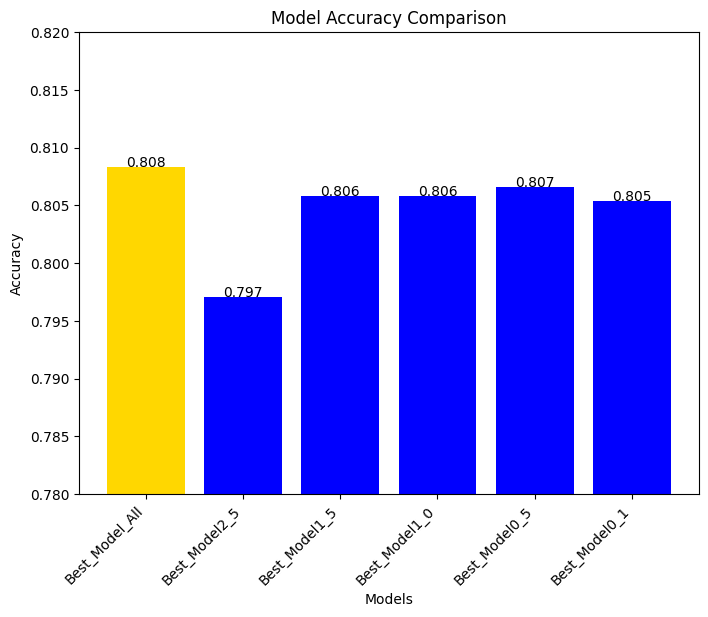

In [42]:
#Let's graph our model performances!
model_names = ['Best_Model_All', 'Best_Model2_5', 'Best_Model1_5', 'Best_Model1_0', 'Best_Model0_5', 'Best_Model0_1']
model_accuracies = [Best_Score_All, Best_Score2_5, Best_Score1_5, Best_Score1_0, Best_Score0_5, Best_Score0_1]
bar_colors = ['gold' if name == 'Best_Model_All' else 'blue' for name in model_names]
plt.figure(figsize = (8,6))
plt.bar(model_names, model_accuracies, color = bar_colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.78, 0.82)
plt.xticks(rotation=45, ha = 'right')

for i, acc in enumerate(model_accuracies):
    plt.text(i, acc, f'{acc:.3f}', ha = 'center', fontsize = 10)

plt.show()

In [43]:
y_pred_Best_Model = cross_val_predict(Best_Model0_1, X, y, cv = 10)
print(confusion_matrix(y,y_pred_Best_Model))
print(classification_report(y, y_pred_Best_Model))

[[3586  729]
 [1156 3222]]
              precision    recall  f1-score   support

       False       0.76      0.83      0.79      4315
        True       0.82      0.74      0.77      4378

    accuracy                           0.78      8693
   macro avg       0.79      0.78      0.78      8693
weighted avg       0.79      0.78      0.78      8693



Looks like our main model with all columns did better than any of those! Looks like we should stick with the original one then! <br>
Considering we're using a 21st century computer that is about 900 years behind the times, that's actually pretty impressive! Let's use our best model to create the predictions to submit to kaggle.com:

### First thing we'll need to do is pre-process our Test data
.... in the same way we did our Train data. Luckily, we created functions for all the pre-processing steps, all of which only require our dataframe, so we can nest each section together to clean things all in one line of code:

In [44]:
#All the Cleaning steps:
df_test = Clean_Pt5(Clean_Pt4(Clean_Pt3(Clean_Pt2(Clean_Pt1(df_test)))))

There are 0 values missing from HomePlanet, Destination, or VIP
There are 0 passengers who spent money while cryosleeping, 
and 222 passengers who spent no money while not frozen
Only 8.41% of Non-frozen passengers have foregone luxuries for the whole trip
There are 0 missing values in the CryoSleep column now!


In [45]:
#Transform Skewed Values
df_test = Transform_Pt1(df_test)

In [46]:
#All the Feature Engineering steps:
df_test = Feature_Eng4(Feature_Eng3(Feature_Eng2(Feature_Eng1(df_test))))

In [47]:
#One-Hot encoding and Normalizing variables:
df_test = Normalize(One_Hot_Encode(df_test))

In [48]:
#Remove Index column
X_Test = df_test.drop(['PassengerId'], axis = 1)

#### Alright time for some unit tests.
Let's assert some stuff, and if no errors pop up, we're good to go:

In [49]:
X_Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   bool   
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   bool   
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   Cabin_No                   4277 non-null   float64
 9   ID_Group                   4277 non-null   float64
 10  ID_No                      4277 non-null   float64
 11  Deck_B                     4277 non-null   bool   
 12  Deck_C                     4277 non-null   bool   
 13  Deck_D                     4277 non-null   bool 

In [50]:
#train data has 23 columns, so our test data should too.
num_cols_test = len(X_Test.columns)
assert num_cols_test == 23, "Unexpected Columns in Bagging Area!"

In [51]:
#test data should contain only Boolean and float64 items
assert all(X_Test.dtypes.apply(lambda x: np.issubdtype(x, np.bool_) or np.issubdtype(x, np.float64))), "Unexpected data types found!"

In [52]:
#test data floats should be less than or equal to 1, unless there's a small floating point rounding error
assert (X_Test.select_dtypes(include=[np.float64]) <= 1 + 1e-9).all().all(), "Float values exceed 1!"

Alright, we've processed our test data and run a few unit tests to verify test data is how we expect it to look! Now it's time to create predictions on those 

In [53]:
y_preds = Best_Model_All.predict(X_Test)
y_probabilities = Best_Model_All.predict_proba(X_Test)
#print(y_probabilities)
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': y_preds, 'Prob_false': y_probabilities[:,0], 'Prob_true': y_probabilities[:,1]})
output.head()
output.to_csv('SubmissionAll.csv', index=False)

Now that the predictions are created, only one thing left to do! Submit them on Kaggle and see how many passengers we managed to save.

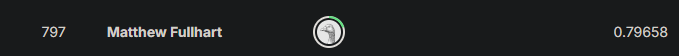

In [54]:
Kaggle_results = Image.open("Kaggle Results.png")
display(Kaggle_results)

Wow, we've managed to place 797th place, out of 2,125 current entries, placing us close to the top third of results. We also blew past our goal of 75% accuracy!

## Resources I used:


Breiman, L. (2001). RANDOM FORESTS. Machine Learning, 32. <br>
GridSearchCV - scikit-learn 1.7.dev0 documentation. (2024, December 10). Retrieved from scikit-learn.org: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html <br>
Kohavi, R. (1995). A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection. International Joint Conference on Artificial Intelligence (IJCAI), (pp. 1137-1143). <br>
Spaceship Titanic | Kaggle. (2024, December 08). Retrieved from Kaggle.com: https://www.kaggle.com/competitions/spaceship-titanic/overview

